# Рекомендательные системы

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

Содержимое директории %s: %s /Users/adzhumurat/PycharmProjects/ai_product_engineer/data ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data', 'content_catalog.zip', 'user_item_views.zip', 'pipelines-data', 'zinc_data', 'model.cb', 'content_views.csv.gz', 'nltk-data', 'Health_and_Personal_Care.jsonl.gz', 'geo_points.csv.gzip', 'clustering.pkl', 'eigen.pkl', 'boosting_toy_dataset.csv', 'mlflow', 'test_dataset.pkl', 'insurance.csv', 'models', 'ground_truth_dataset.pkl', 'minio', 'rtb_classification_data.csv.gz', 'final_dataset.zip', 'content_views.csv', 'sales_timeseries_dataset.csv.gz', 'logs', 'ocr_dataset.zip', 'content_description.csv.gz', 'task.csv', 'scored_corpus.csv', 'meta_Health_and_Personal_Care.jsonl.gz', 'best_model.cb', 'brand_tweets.csv', 'brand_tweets_valid.csv', 'non_linear.csv']


Датасет для обучения рекомендательных систем содержит следующие данные

* csv `user_item_views.zip` на ~2 млн строк вида

| user_id | item_id	| show_timestamp | show_duration |
| --- | --- | --- | --- |
| 912948920 | 1587935070 | 1119307 | 323 |

* архив `data/content_catalog.zip` содержит csv с названиями контента в формате

| item_id | title |
| --- | --- |
| 1593139110 | Тачки 3 |

* архив `data/json_views.tar.gz` содержит single-line JSON вида

```json
{"value": 6127, "date": 1606254752, "validation": 0, "item_id": 930420160, "user_id": 399644822}
```

* pickle `ground_truth_dataset.pkl` с просмотрами контента за 1 день по 13353 пользователям
* pickle `test_dataset.pkl` с просмотрами контента за 180 предшествующих дней по 13353 пользователям

Бинарный файл `ground_truth_dataset.pkl` это массив где каждый элемент представляет собой
записи из `json_views.tar.gz` агрегированные по полю `user_id` в словарь вида `{item_id: value, ..., item_id: value}`,
с флагом `is_validation=1`

В файле `test_dataset.pkl` содержатся такие же записи, но с флагом `is_validation=0`.

Загружаем табличные данные для подсчёта статистик

In [2]:
import pandas as pd

user_item_data_file_path = os.path.join(root_data_dir, 'user_item_views.zip')

user_item_views_df = pd.read_csv(user_item_data_file_path, compression='zip')
print('num rows: %d' % user_item_views_df.shape[0])
user_item_views_df.head(3)

num rows: 1975696


,user_id,item_id,show_timestamp,show_duration
0,912948920,1587935070,1119307,323
1,1882728205,1466874188,1115796,1428
2,382105433,276839040,1116585,921


Каталог контента

In [3]:
catalog_file_path = os.path.join(root_data_dir, 'content_catalog.zip')
content_catalog = pd.read_csv(catalog_file_path, compression='zip')

content_catalog.head(5)

,item_id,title
0,448991742,Кэндимен
1,1131986063,Горячие головы
2,1835073733,После дождичка в четверг
3,1792204487,Сокровища О.К.
4,5589796,Затура: Космическое приключение


Тестовый и валидационный наборы данных

In [4]:
import pickle

with open(os.path.join(root_data_dir, 'ground_truth_dataset.pkl'), 'rb') as f:
    ground_truth_dataset = pickle.load(f)
with open(os.path.join(root_data_dir, 'test_dataset.pkl'), 'rb') as f:
    test_dataset = pickle.load(f)
print(
    'test dataset users %d, valid dataset users %d' %
    (len(test_dataset), len(ground_truth_dataset))
)

test dataset users 13163, valid dataset users 13163


Алгоритмы рекомендательных систем работают с матрицей user-item
* число строк совпадает с количеством пользователей
* число столбцов совпадает с количестовом контента
* на пересечении строки и столбца стоит единица в случае, если просмотр присутствовал в датасете и ноль если такого просмотра не было

Т.к. контента в системе намного больше, чем может посмотреть пользователь, то такая матрица называется разреженной (мы встречали такую в занятии по tf-idf)

Для трансформации в csr нужно перевести `user_id` в индекс строки, а `content_id` в индекс столбца. Создаём индексы

In [7]:
unique_users = user_item_views_df.user_id.unique()
unique_items = user_item_views_df.item_id.unique()

# премая и обратная индексация контента
item_to_id = {j: i for i, j in enumerate(unique_items)}
id_to_item = {j: i for i, j in item_to_id.items()}

# прямая и обратная индексация пользователей
user_to_id = {j: i for i, j in enumerate(unique_users)}
print('Индекс создан: %d строк %d столбцов' % (len(user_to_id), len(item_to_id)))

Индекс создан: 168756 строк 9991 столбцов


## Трансформация в csr

Для каждого пользователя оставляем top-20 последних просмотров чтобы матрица не получилась сишком большой

In [8]:
HISTORY_TOP = 20
# применяем оконную функцию
user_item_views_df['rank'] = (
    user_item_views_df
    .groupby(by=['user_id'])['show_timestamp']
    .rank(method='first', ascending=False)
)
ui_slim_df = (
    user_item_views_df[user_item_views_df['rank'] < HISTORY_TOP][['user_id', 'item_id']]
)

ui_slim_df.head()

,user_id,item_id
0,912948920,1587935070
1,1882728205,1466874188
2,382105433,276839040
3,1030600713,401051817
4,743755331,1193027362


Создаём матрицу

In [9]:
from scipy.sparse import csr_matrix

num_rows = len(user_to_id)
num_cols = len(item_to_id)
entries = np.ones(ui_slim_df.shape[0])  # проставляем ненулевые элементы - единицы
rows = tuple(user_to_id[i] for i in ui_slim_df.user_id.values)
cols = tuple(item_to_id[i] for i in ui_slim_df.item_id.values)

train_set_csr = csr_matrix(
    (entries, (rows, cols)),
    shape=(num_rows, num_cols),
    dtype=np.float32
)
train_set_csr

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1433407 stored elements and shape (168756, 9991)>

Обучение модели

In [10]:
run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
    from IPython.display import clear_output
    !pip install implicit==0.5.2
    
    clear_output()
print('Implicit installed')

Implicit installed


In [11]:
import os
from implicit.als import AlternatingLeastSquares

os.environ['OPENBLAS_NUM_THREADS'] = '1'

implict_als_params = {'factors': 4, 'iterations': 1}
model = AlternatingLeastSquares(**implict_als_params)
# на вход подаём матрицу user_item
model.fit(train_set_csr)

  0%|          | 0/1 [00:00<?, ?it/s]

Пример работы модели достаём историю просмотров случайного пользователя

На вход ALS идёт CSR матрица с просмотренным контентом, по которой генерируются рекомендации

In [12]:
def id_to_content_df(ids: np.array, content_df: pd.DataFrame, id_to_item):
    items = tuple(id_to_item[i] for i in ids)
    result_df = content_catalog[
        content_catalog.item_id.isin(items)
    ]
    return result_df

# csr матрица на вход ALS
random_history = train_set_csr[np.random.randint(low=0, high=train_set_csr.shape[0])]
id_to_content_df(random_history.nonzero()[1], content_catalog, id_to_item)

,item_id,title
1148,1965687007,Война миров Z
5640,733867875,Союзники
7103,997565431,Ной
10880,1323560630,Zомбилэнд: Контрольный выстрел
11139,1502288546,Мумия
12108,1095953790,Бронкская история
13091,997620418,Семь психопатов
16232,1141280972,Спящие
26665,1148282040,Просто помиловать
27072,267109624,Хозяин морей: На краю Земли


Приверим, что рекомендует модель для такой истории просмотров

In [13]:
recommended_content, recommended_scores = model.recommend(
            userid = 0,
            user_items=random_history,
            N=10,
            filter_already_liked_items=True,
            recalculate_user=True
)
id_to_content_df(recommended_content, content_catalog, id_to_item)

,item_id,title
1027,1507021169,Тайная жизнь домашних животных 2
1996,777155690,Холодное сердце 2
4098,984316348,Гарри Поттер и Принц-полукровка
4688,446911865,Фиксики: Большой секрет
6631,600517301,Зов предков
11546,656476023,Angry Birds 2 в кино
13080,1470124757,Мулан
13380,1757140863,Корпорация монстров
16205,1687588185,Щенячий патруль: Мегащенки
27442,157249585,Капоне. Лицо со шрамом


Готовим валидационный и тестовый сет

```shell
SCRIPT=prepare_implicit_train_test_set.py make run-script
```

Объединяем историю пользователя и валидационный сет

In [15]:
test_dataset_path = os.path.join(root_data_dir, 'pipelines-data', 'test_embeds.npy')
train_dataset_path = os.path.join(root_data_dir, 'pipelines-data', 'train_embeds.npy')

print('Embeds loading started...')
test_dataset_vectors = np.load(test_dataset_path)
ground_truth_dataset_vectors = np.load(train_dataset_path)
print(f'Embeds loading finished! Num test vectors: {test_dataset_vectors.shape}')

train_valid_pairs = []
for test_user_id in range(len(test_dataset_vectors)):
    train_valid_pairs.append((
        csr_matrix(test_dataset_vectors[test_user_id]),  # csr матрица на вход ALS
        ground_truth_dataset_vectors[test_user_id].nonzero()[0]
    ))
print('validation prepared')

Embeds loading started...
Embeds loading finished! Num test vectors: (13163, 9991)
validation prepared


In [17]:
train_valid_pairs[0]

(<Compressed Sparse Row sparse matrix of dtype 'float32'
 	with 11 stored elements and shape (1, 9991)>,
 array([2325]))

## Бейзлайны

Рандомные рекомендации

In [22]:
from recsys.validation import randomized

content_popularity = np.asarray(train_set_csr.sum(axis=0)).reshape(-1)
all_content = np.array(list(id_to_item.keys()))

randomized
print(randomized(all_content, train_valid_pairs))

Num hits 0.0102 from 13163


Если делать предсказания рандомно, угадываем всего в 1% случаев

# Неперсональные рекомендации: популярность

Что будет, если рекомендовать популярный контент (всем один и тот же список)

In [23]:
from recsys.validation import top_popular

N = 40
content_popularity = np.asarray(train_set_csr.sum(axis=0)).reshape(-1)
top_100_popular_items = np.argsort(-content_popularity)[:100]

print(top_popular(top_100_popular_items, train_valid_pairs))

Num hits 0.2079 from 13163


Видим рост качества в десятки раз, популярность - мощный бейзлайн

## Персональные рекомедации

Наконец, воспользуемся ALS. Обучим модель

In [24]:
implict_als_params = {'factors': 20, 'iterations': 30}
model = AlternatingLeastSquares(**implict_als_params)
print('train started')
model.fit(train_set_csr)
print('train finished')

train started


  0%|          | 0/30 [00:00<?, ?it/s]

train finished


Персональные рекомендации

In [26]:
from tqdm import tqdm

N = 50
testing_model = model

def top_n_recommends_personal(watch_history):
    top_n_result, recommended_scores = testing_model.recommend(
            userid = 0,
            user_items=watch_history[0],
            N=N,
            filter_already_liked_items=True,
            recalculate_user=True
    )
    hit = 0
    if len(watch_history[1]) > 0 and np.intersect1d(watch_history[1], top_n_result).size > 0:
        hit = 1
    return hit

NUM_PROCESSES = 2
print('Prediction started')
hits = [top_n_recommends_personal(i) for i in train_valid_pairs]
print('Num hits %.4f from %d' % (sum(hits)/len(hits), len(hits)))

Prediction started
Num hits 0.2594 from 13163


In [27]:
testing_model.item_factors.shape

(9991, 20)

In [28]:
testing_model.user_factors.shape

(168756, 20)

In [ ]:
from numpy import save, load

item_factors_file_path = os.path.join(root_data_dir, 'item_factors.zip')

# save(item_factors_file_path, testing_model.item_factors)
# logger.info('saved to %s', item_factors_file_path)

# item_factors = load(item_factors_file_path)
# logger.info('saved to %s', item_factors_file_path)

Чтобы как-то проверить качество полученных эмбеддингов, визуализируем их с помощью UMAP

In [30]:
run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
    from IPython.display import clear_output
    !pip install umap-learn
    
    clear_output()
print('umap installed')


umap installed


In [31]:


from umap import UMAP

print('umap started...')
manifold = UMAP(random_state=RANDOM_SEED, n_components=2).fit(testing_model.item_factors)
X_umap = manifold.transform(testing_model.item_factors)
print('umap finished...')

umap started...


/Users/adzhumurat/PycharmProjects/ai_product_engineer/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap finished...


К сожалению, визуально кластера не отделяются

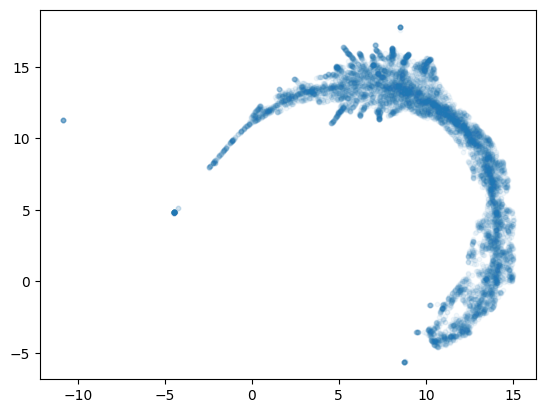

In [32]:
from matplotlib import pyplot as plt

plt.scatter(X_umap[:,0], X_umap[:,1], s=10, alpha=0.05)
plt.show()

Попробуем прогнать через DBSCAN

Число кластеров: 31


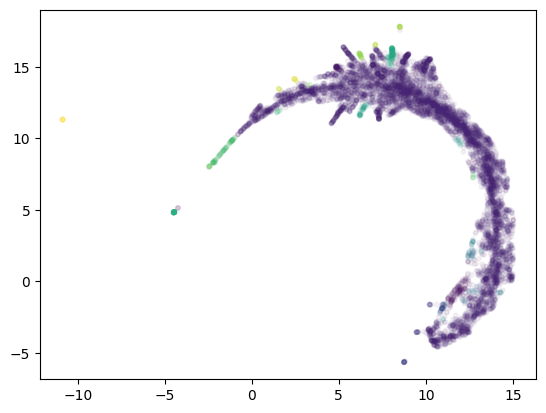

In [34]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.15, min_samples=5, leaf_size=10).fit(X_umap)
print('Число кластеров: %d' %  len(np.unique(clustering.labels_)))
plt.scatter(X_umap[:,0], X_umap[:,1], s=10, alpha=0.05, c=clustering.labels_)
plt.show()

Особо ничего не вышло(

# Итог

* построили две модели: персональную и неперсональную
* применили техники снижения резмерности